# Move global forcing files to regional domain with new bathymetry

In [3]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/users/birgal/')
from nemo_python.ics_obcs import fill_ocean
from nemo_python.interpolation import neighbours

#### Functions

In [2]:
def subset_global(file_path, nemo_mask, fill_ocn=False):

    ds = xr.open_dataset(f'{file_path}').isel(y=slice(0,453))

    if fill_ocn:
        for var in list(ds.keys()):
            # Check for values that are NaN and in the ocean
            # cond      = (mesh_new.tmask.isel(time_counter=0, nav_lev=0) == 1)*np.isnan(ds[var]) 
            ds_filled = fill_ocean(ds.isel(time_counter=0), var, nemo_mask)
    
    new_file_path = file_path.replace(file_path.split('/')[-1], f"AntArc_{file_path.split('/')[-1]}") 
    ds.to_netcdf(f"{new_file_path}")
    
    return 

In [ ]:
sum(sum(np.isnan(iwm_ds.isel(y=slice(0,453), time_counter=0).values)))

In [ ]:
iwm_powerbot_filled = fill_ocean(iwm_ds.isel(y=slice(0,453), time_counter=0), 'power_bot', mesh_new)

### Main

In [5]:
domain_old   = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-old.nc')
domain_new   = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20231025-filledlakes.nc')
mesh_new     = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231025-filledlakes.nc')

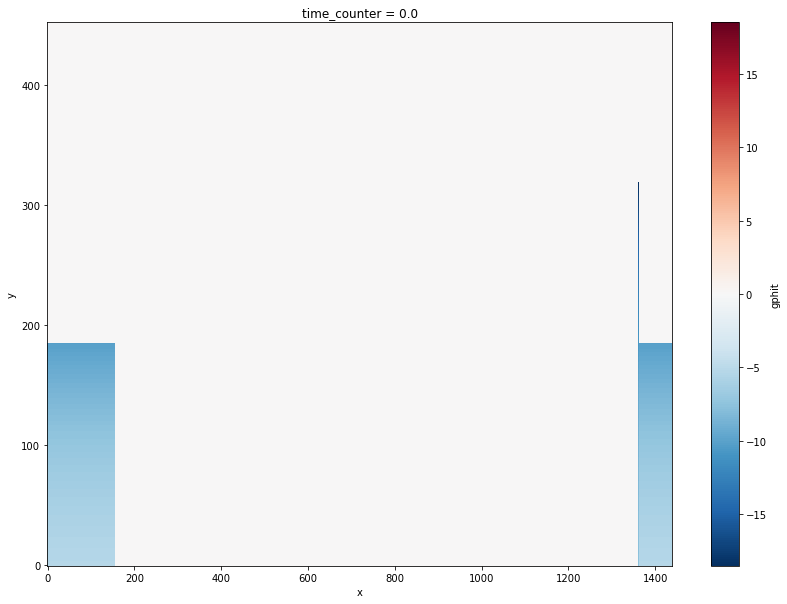

In [80]:
(domain_new.gphit.isel(time_counter=0)-(iwm_ds.gphit.isel(y=slice(0,453)))).plot(figsize=(14,10))

In [ ]:
# Load global files
folder      = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/misc-forcing/'
files_coast = ['eORCA025_calving_b0.2_v2.3_nohls.nc', 'eORCA025_distcoast_b0.2_v0.0_nohls.nc', 
               'eORCA025_runoff_b0.2_v0.0_nohls.nc']
# mv_ocn   = ~fill_ocn # move values from land to the nearest ocean point
# mv_to_coast = fill_ocn # move non-zero values to the new land-edge

# subset files:
# - internal wave field --- fill with connected nearest neighbour
subset_global(f'{folder}eORCA025_iwm_b0.2_v1.0_nohls.nc', fill_ocn=True)
# - bottom friction  / turbulence --- leave as zeros
subset_global(f'{folder}eORCA025_shlat2d_v0.2_nohls.nc' , fill_ocn=False)
subset_global(f'{folder}eORCA025_bfr2d_v0.2_nohls.nc'   , fill_ocn=False)
# - distance to the coast --- recalculate for new bathymetry
# - runoff --- use list of first point in the ocean to move runoff to this cell 
#             (don't need to do in this case because I'm not running with runoff)
# - calving --- check that these are close enough to the iceshelf edge to be fine:
#               check distcoast to first point on land at each point where calving happens
#               if distcoast=0 (on land) where calving is nonzero, move the calving to the nearest point where distcoast!=0 and check that imask nearby
#               if calving is nonzero and distcoast > 10 km (or some other value), move the calving closer to the coastline

In [ ]:
# Function that finds a list of the coordinates of the coastline points (first point on land and first point in the ocean)
# then, calculate the distance for each ocean point to each coastline point and keep the closest coastline point distance
def find_coastline(nemo_mask)

    
    # returns list of first points on land and first points in the ocean

    return land, ocean


# Helper function to calculate the Euclidean distance between two longitude and latitude points
def calc_distance():


    return

In [15]:
coast_mask = get_coast_mask(mesh_new)

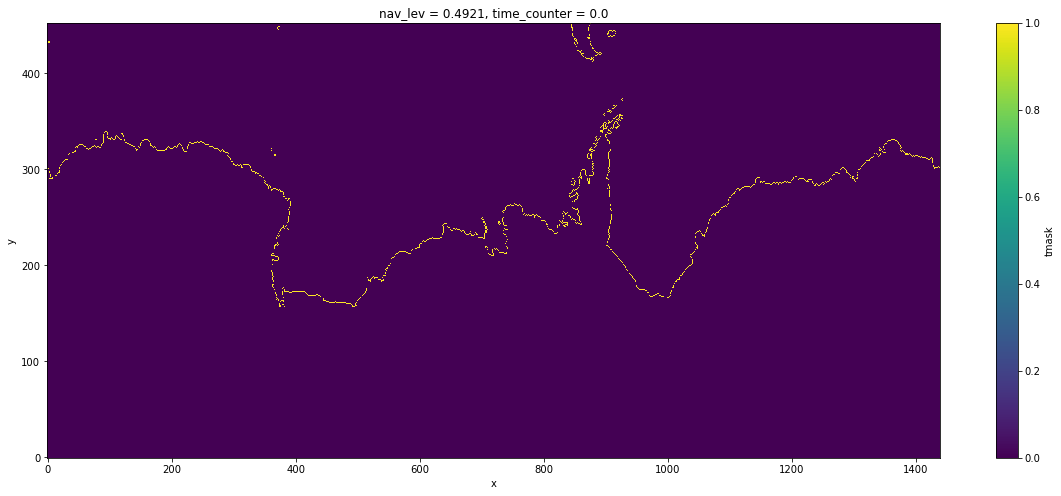

In [20]:
coast_mask.isel(nav_lev=0).plot(figsize=(20,8))

In [14]:
# Build and return a T grid mask for coastal points: open-ocean points with at least one neighbour that is land or ice shelf.
def get_coast_mask(mask):
    
    open_ocean = (mask.tmask.isel(time_counter=0) == 1)
    land_ice   = ~open_ocean
    
    num_coast_neighbours = neighbours(land_ice, missing_val=0)[-1]
    coast_mask           = (open_ocean*(num_coast_neighbours > 0)).astype(bool)
    
    return coast_mask

In [ ]:
  # Build and return a mask for the ice shelf front points of the given ice shelf.
def get_icefront_mask (self, shelf='all', gtype='t', is_3d=False, side='ice'):
        
    ice_mask = self.get_ice_mask(shelf=shelf, gtype=gtype)
    mask     = ice_shelf_front_points(self, ice_mask=ice_mask, xmin=None, xmax=None, ymin=None, ymax=None, side=side)
    if is_3d:
        mask = mask_2d_to_3d(mask, self)
    return mask

# Return the ice shelf mask for the given grid type.
def get_ice_mask (self, gtype='t'):

    # Select grid type
    if gtype == 't':
        ice_mask_all = self.ice_mask
    elif gtype == 'u':
        ice_mask_all = self.ice_mask_u
    elif gtype == 'v':
        ice_mask_all = self.ice_mask_v
    else:
        raise Exception(f'Error (get_ice_mask): no mask exists for the {gtype} grid')
        
    return ice_mask_all

In [ ]:
# https://benalexkeen.com/implementing-djikstras-shortest-path-algorithm-with-python/
# https://towardsdatascience.com/compute-the-distance-matrix-of-a-set-of-sites-from-their-coordinates-in-python-d5fc92a0ba9e